In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings
import gsw  

#=================================================
# Modify paths to point to output files
#=================================================
# Case name (Straight coast)
case_straight = 'Straight Coast'

# path to ocean_annual file
path_year_straight = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/600yr/24000101.ocean_annual.nc'
dy_straight = xr.open_dataset(path_year_straight, decode_times=True)

# path to ocean_month file
path_month_straight = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/600yr/24000101.ocean_month.nc'
dm_straight = xr.open_dataset(path_month_straight, decode_times=True)

# path to ice_month file
path_month_straight = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/600yr/24000101.ice_month.nc'
di_straight = xr.open_dataset(path_month_straight, decode_times=True)


# Case name (Both Coast)
case_both = 'Both Coast'

# path to ocean_annual file
path_year_both = '/data/sragen/aquaplanet/MASTERS/both_coast/run/DATA/500yr/23000101.ocean_annual.nc'
dy_both = xr.open_dataset(path_year_both, decode_times=True)

# path to ocean_month file
path_month_both = '/data/sragen/aquaplanet/MASTERS/both_coast/run/DATA//500yr/23000101.ocean_month.nc'
dm_both = xr.open_dataset(path_month_both, decode_times=True)

# path to ice_month file
path_month_both = '/data/sragen/aquaplanet/MASTERS/both_coast/run/DATA//500yr/23000101.ice_month.nc'
di_both = xr.open_dataset(path_month_both, decode_times=True)


# Case name (America Coast)
case_am = 'America Coast'

# path to ocean_annual file
path_year_am = '/data/sragen/aquaplanet/MASTERS/am_coast/run/DATA/500yr/23000101.ocean_annual.nc'
dy_am = xr.open_dataset(path_year_am, decode_times=True)

# path to ocean_month file
path_month_am = '/data/sragen/aquaplanet/MASTERS/am_coast/run/DATA/500yr/23000101.ocean_month.nc'
dm_am = xr.open_dataset(path_month_am, decode_times=True)

# path to ice_month file
path_month_am = '/data/sragen/aquaplanet/MASTERS/am_coast/run/DATA/500yr/23000101.ice_month.nc'
di_am = xr.open_dataset(path_month_am, decode_times=True)


# Case name (Africa Coast)
case_af = 'Africa Coast'

# path to ocean_annual file
path_year_af = '/data/sragen/aquaplanet/MASTERS/af_coast/run/DATA/500yr/23000101.ocean_annual.nc'
dy_af = xr.open_dataset(path_year_af, decode_times=True)

# path to ocean_month file
path_month_af = '/data/sragen/aquaplanet/MASTERS/af_coast/run/DATA/500yr/23000101.ocean_month.nc'
dm_af = xr.open_dataset(path_month_af, decode_times=True)

# path to ice_month file
path_month_af = '/data/sragen/aquaplanet/MASTERS/af_coast/run/DATA/500yr/23000101.ice_month.nc'
di_af = xr.open_dataset(path_month_af, decode_times=True)


#=================================================
# Ignore runtime warnings: mean of empty slice
#=================================================
warnings.filterwarnings("ignore", message="Mean of empty slice")

#=================================================
# Modify latitudes to point to western and eastern
# boundaries of small basin and northern extent of SO.
# Comment out for AQUA and RIDGE cases. 
#=================================================
x_west = np.where(dy_straight['xh']==211)[0][0]
x_east = np.where(dy_straight['xh']==351)[0][0]
y = np.where(dy_straight['yq']==-35)[0][0]
y_south = np.where(dy_straight['yq']==-71)[0][0]
y_north = np.where(dy_straight['yq']==71)[0][0]

/home/sragen/.conda/envs/aqua/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [10]:
def calc_sigma0(dy_case, salt, temp):
    CT = xr.apply_ufunc(gsw.CT_from_pt, salt, temp, dask='parallelized', output_dtypes=[float,])

    sigma0 = xr.apply_ufunc(gsw.sigma0, salt, CT, dask='parallelized', output_dtypes=[float,])
    
    sigma0_xarray = temp.copy()
    sigma0_xarray.attrs['units'] = 'kg/m^3' 
    sigma0_xarray.attrs['long_name'] = 'potential density referenced to surface density'
    sigma0_xarray.attrs['standard_name'] = 'sigma0'
    sigma0_xarray.values = sigma0
    
    return sigma0_xarray


def plot_sigma0(sigma0, dy_case, case, lower_bound=0, upper_bound=35, cm='BuPu'):
    b = np.linspace(lower_bound, upper_bound, 21, endpoint=True)
    t = np.linspace(lower_bound, upper_bound, 11, endpoint=True)
    fig = plt.figure(figsize=(14, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180.0))
    plt.contourf(dy_case.xh, dy_case.yh, sigma0[-361:-1,:,:].mean(dim='time'), b, extend='both', 
             cmap=cm, transform=ccrs.PlateCarree())
    cbar = plt.colorbar(ticks=t, boundaries=t, spacing='uniform', extend='both')
    cbar.ax.set_ylabel('[kg m$^{-3}$]', fontsize=14)
    plt.ylabel('Latitude', fontsize=14), plt.xlabel('Longitude', fontsize=14)
    plt.title('{} $\sigma_0$'.format(case), fontsize=16)
    # plt.savefig(fig_path+'MLD_DJF.png')
    plt.show()
    return


def volume_transport(dy_case, case):
    new_lon = np.r_[-1, dy_case.xh]
    dlon_np = np.diff(new_lon)
    dlon = dy_case.xh.copy()
    dlon.values = dlon_np

    dx = np.cos(np.deg2rad(dy_case.yq))* dlon.isel(xh=0) * 111000

    new_z = np.r_[0, dy_case.zl]
    dz_np = np.diff(new_z)
    dz = dy_case.zl.copy()
    dz.values = dz_np
    
    dy_case.vo * dx * dz

    voltran = dy_case.vo * np.abs(dx) * np.abs(dz)
    voltran = voltran.sum(dim='zl').sum(dim='xh')
    return voltran



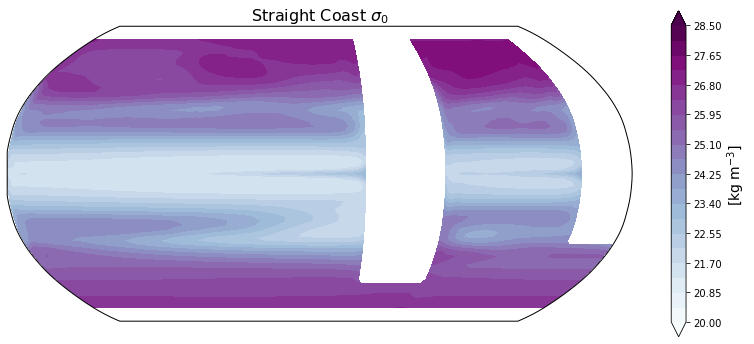

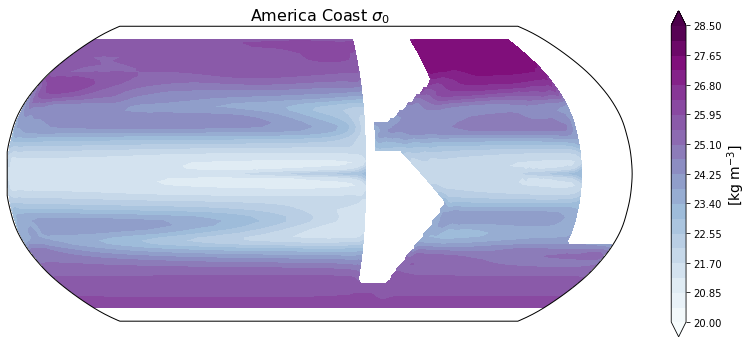

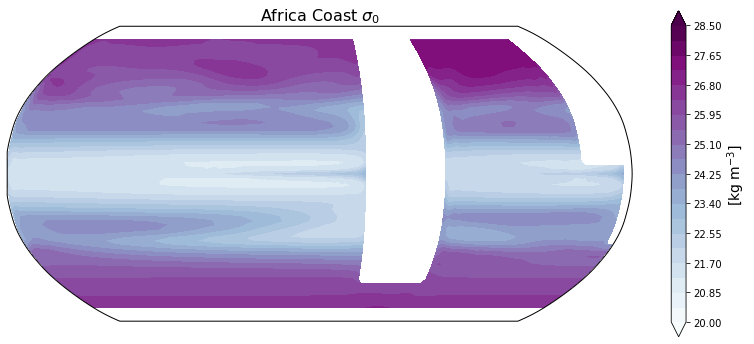

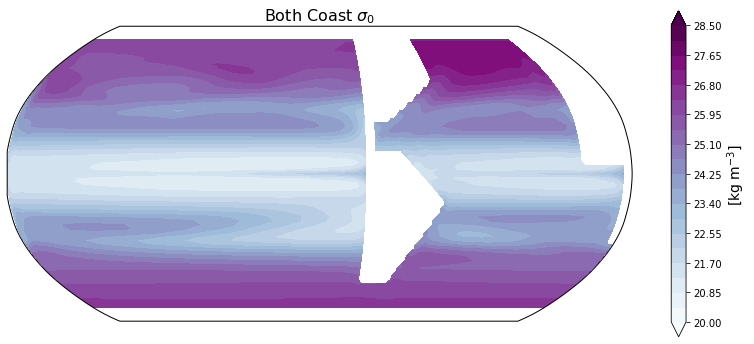

In [5]:
sigma0_straight = calc_sigma0(dy_straight, dy_straight.sos, dy_straight.tos)
plot_sigma0(sigma0_straight, dy_straight, case_straight, lower_bound=20, upper_bound=28.5)

sigma0_am = calc_sigma0(dy_am, dy_am.sos, dy_am.tos)
plot_sigma0(sigma0_am, dy_am, case_am, lower_bound=20, upper_bound=28.5)

sigma0_af = calc_sigma0(dy_af, dy_af.sos, dy_af.tos)
plot_sigma0(sigma0_af, dy_af, case_af, lower_bound=20, upper_bound=28.5)

sigma0_both = calc_sigma0(dy_both, dy_both.sos, dy_both.tos)
plot_sigma0(sigma0_both, dy_both, case_both, lower_bound=20, upper_bound=28.5)


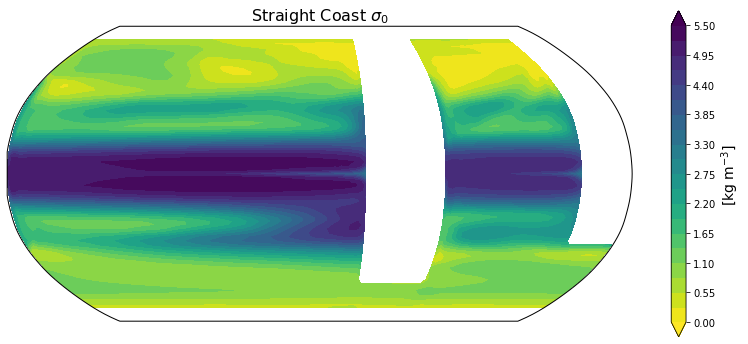

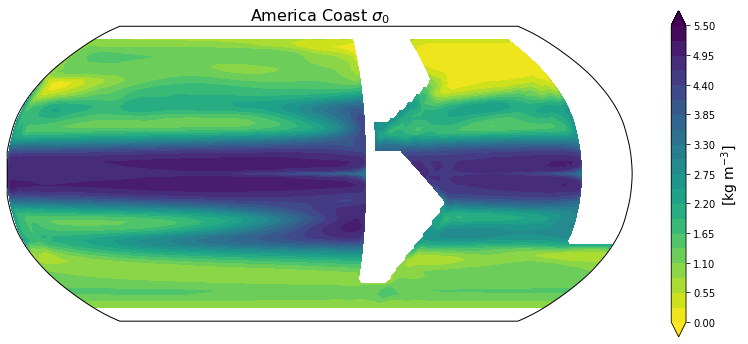

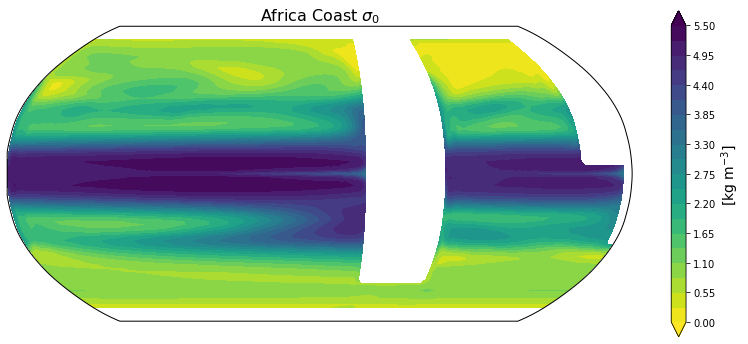

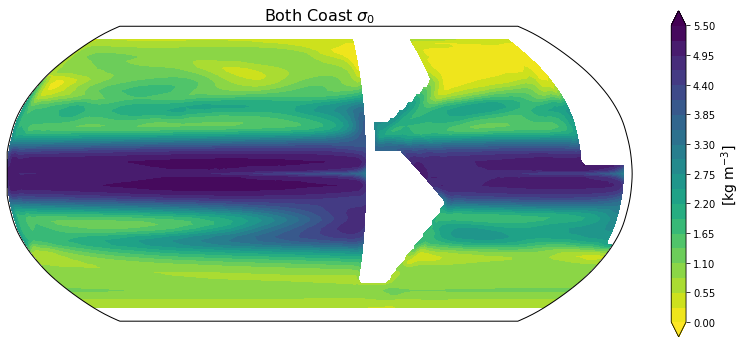

In [6]:
rho300_straight = calc_sigma0(dy_straight, dy_straight.so.sel(zl=312.5), dy_straight.thetao.sel(zl=312.5))
drho_straight = rho300_straight - sigma0_straight
# drho_straight.mean(dim='time').plot(); plt.show()
plot_sigma0(drho_straight, dy_straight, case_straight, lower_bound=0, upper_bound=5.5, cm='viridis_r')


rho300_am = calc_sigma0(dy_am, dy_am.so.sel(zl=312.5), dy_am.thetao.sel(zl=312.5))
drho_am = rho300_am - sigma0_am
# drho_am.mean(dim='time').plot(); plt.show()
plot_sigma0(drho_am, dy_am, case_am, lower_bound=0, upper_bound=5.5, cm='viridis_r')

rho300_af = calc_sigma0(dy_af, dy_af.so.sel(zl=312.5), dy_af.thetao.sel(zl=312.5))
drho_af = rho300_af - sigma0_af
# drho_af.mean(dim='time').plot(); plt.show()
plot_sigma0(drho_af, dy_af, case_af, lower_bound=0, upper_bound=5.5, cm='viridis_r')

rho300_both = calc_sigma0(dy_both, dy_both.so.sel(zl=312.5), dy_both.thetao.sel(zl=312.5))
drho_both = rho300_both - sigma0_both
# drho_both.mean(dim='time').plot(); plt.show()
plot_sigma0(drho_both, dy_both, case_both, lower_bound=0, upper_bound=5.5, cm='viridis_r')


In [7]:
# g = 9.81          # m^2/s
# rho_0 = 1025      # kg/m^3

# dz = dy_straight.zl.sel(zl=312.5) - dy_straight.zl.isel(zl=0)
# N2_300_straight = g/rho_0 * drho/dz
# N2_300_straight.mean(dim='time').plot()

In [8]:
# SSH snapshots (25, 50, 100, 200, 300 years, etc.)
# SSS snapshots (first 15 years)
# AMOC snapshots (10, 20, 30, 50, 75, 100 years)

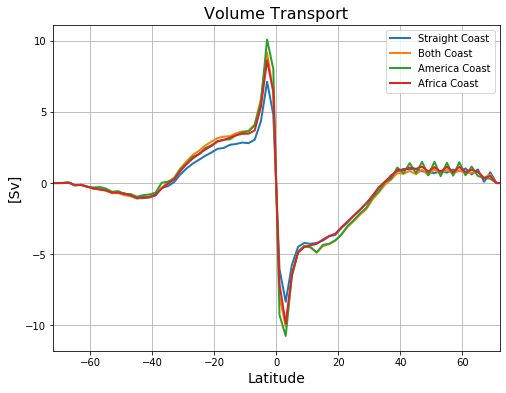

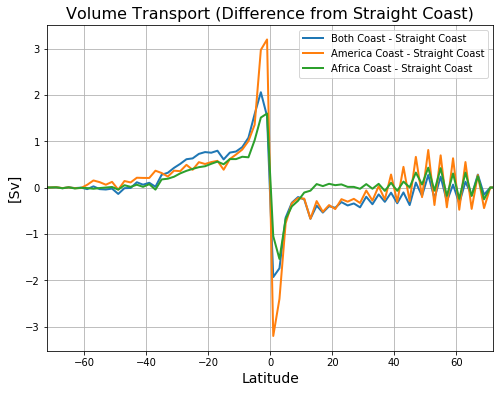

In [11]:
# Meridional volume transport plotted against latitude

voltran_straight = volume_transport(dy_straight, case_straight)
voltran_both = volume_transport(dy_both, case_both)
voltran_am = volume_transport(dy_am, case_am)
voltran_af = volume_transport(dy_af, case_af)

voltran_straight = voltran_straight.isel(time=slice(-37,-1)).mean(dim='time')/1e6
voltran_both = voltran_both.isel(time=slice(-37,-1)).mean(dim='time')/1e6
voltran_am = voltran_am.isel(time=slice(-37,-1)).mean(dim='time')/1e6
voltran_af = voltran_af.isel(time=slice(-37,-1)).mean(dim='time')/1e6

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dy_straight.yq, voltran_straight, linewidth=2, label=case_straight)
ax.plot(dy_both.yq, voltran_both, linewidth=2, label=case_both)
ax.plot(dy_am.yq, voltran_am, linewidth=2, label=case_am)
ax.plot(dy_af.yq, voltran_af, linewidth=2, label=case_af)
plt.xlim(-72,72)
plt.title('Volume Transport', fontsize=16) 
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[Sv]', fontsize=14)
plt.grid()
plt.legend()
# plt.savefig(fig_path+'voltran.png')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dy_both.yq, voltran_both-voltran_straight, 
        linewidth=2, label= '{} - {}'.format(case_both, case_straight))
ax.plot(dy_am.yq, voltran_am-voltran_straight, 
        linewidth=2, label= '{} - {}'.format(case_am, case_straight))
ax.plot(dy_af.yq, voltran_af-voltran_straight, 
        linewidth=2, label= '{} - {}'.format(case_af, case_straight))
plt.xlim(-72,72)
plt.title('Volume Transport (Difference from {})'.format(case_straight), fontsize=16) 
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[Sv]', fontsize=14)
plt.grid()
plt.legend()
# plt.savefig(fig_path+'voltran.png')
plt.show()

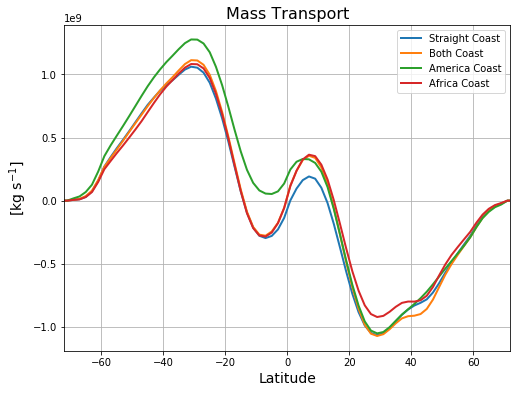

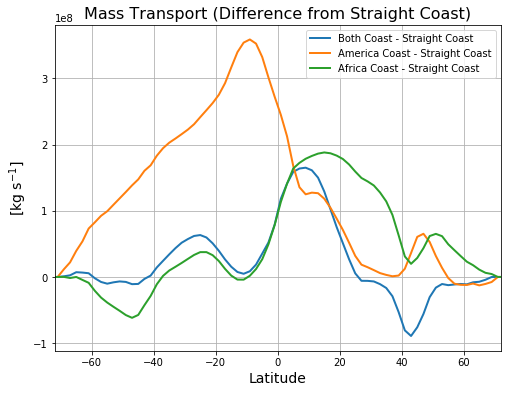

In [8]:
# Meridional mass transport plotted against latitude

masstran_straight = dy_straight.vmo.sum(dim='zl').sum(dim='xh') 
masstran_both = dy_both.vmo.sum(dim='zl').sum(dim='xh') 
masstran_am = dy_am.vmo.sum(dim='zl').sum(dim='xh') 
masstran_af = dy_af.vmo.sum(dim='zl').sum(dim='xh') 

masstran_straight = masstran_straight.isel(time=slice(-37,-1)).mean(dim='time')
masstran_both = masstran_both.isel(time=slice(-37,-1)).mean(dim='time')
masstran_am = masstran_am.isel(time=slice(-37,-1)).mean(dim='time')
masstran_af = masstran_af.isel(time=slice(-37,-1)).mean(dim='time')

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dy_straight.yq, masstran_straight, linewidth=2, label=case_straight)
ax.plot(dy_both.yq, masstran_both, linewidth=2, label=case_both)
ax.plot(dy_am.yq, masstran_am, linewidth=2, label=case_am)
ax.plot(dy_af.yq, masstran_af, linewidth=2, label=case_af)
plt.xlim(-72,72)
plt.title('Mass Transport', fontsize=16) 
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[kg s$^{-1}$]', fontsize=14)
plt.grid()
plt.legend()
# plt.savefig(fig_path+'masstran.png')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dy_both.yq, masstran_both-masstran_straight, linewidth=2, label='{} - {}'.format(case_both, case_straight))
ax.plot(dy_am.yq, masstran_am-masstran_straight, linewidth=2, label='{} - {}'.format(case_am, case_straight))
ax.plot(dy_af.yq, masstran_af-masstran_straight, linewidth=2, label='{} - {}'.format(case_af, case_straight))
plt.xlim(-72,72)
plt.title('Mass Transport (Difference from {})'.format(case_straight), fontsize=16) 
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[kg s$^{-1}$]', fontsize=14)
plt.grid()
plt.legend()
# plt.savefig(fig_path+'masstran.png')
plt.show()

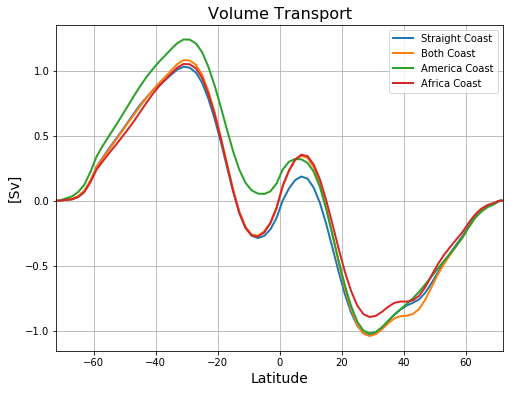

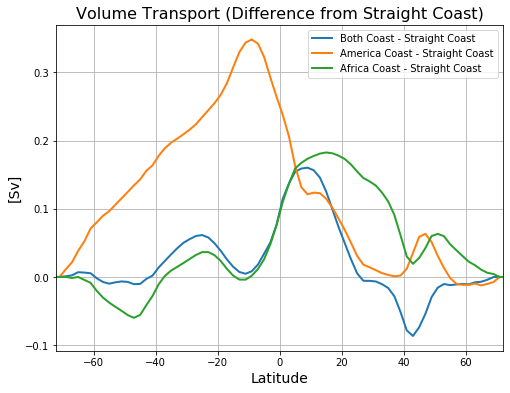

In [32]:
rho = 1030 * 1e6

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dy_straight.yq, masstran_straight/rho, linewidth=2, label=case_straight)
ax.plot(dy_both.yq, masstran_both/rho, linewidth=2, label=case_both)
ax.plot(dy_am.yq, masstran_am/rho, linewidth=2, label=case_am)
ax.plot(dy_af.yq, masstran_af/rho, linewidth=2, label=case_af)
plt.xlim(-72,72)
plt.title('Volume Transport', fontsize=16) 
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[Sv]', fontsize=14)
plt.grid()
plt.legend()
# plt.savefig(fig_path+'masstran.png')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dy_both.yq, (masstran_both-masstran_straight)/rho, linewidth=2, label='{} - {}'.format(case_both, case_straight))
ax.plot(dy_am.yq, (masstran_am-masstran_straight)/rho, linewidth=2, label='{} - {}'.format(case_am, case_straight))
ax.plot(dy_af.yq, (masstran_af-masstran_straight)/rho, linewidth=2, label='{} - {}'.format(case_af, case_straight))
plt.xlim(-72,72)
plt.title('Volume Transport (Difference from {})'.format(case_straight), fontsize=16) 
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[Sv]', fontsize=14)
plt.grid()
plt.legend()
# plt.savefig(fig_path+'masstran.png')
plt.show()

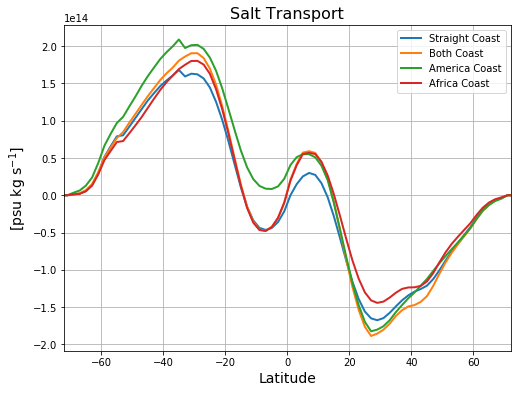

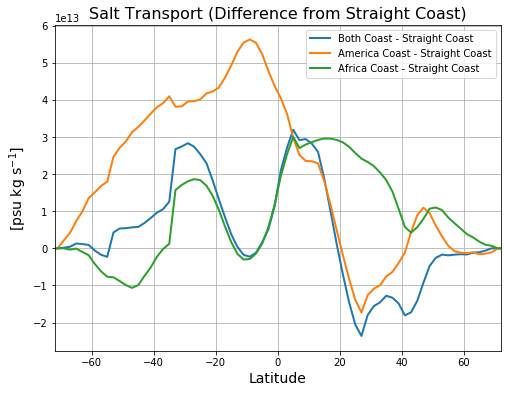

In [9]:
# Meridional salt transport plotted against latitude

so_straight = dy_straight.so.rename({'yh':'yq'})
so_both = dy_both.so.rename({'yh':'yq'})
so_am = dy_am.so.rename({'yh':'yq'})
so_af = dy_af.so.rename({'yh':'yq'})

salttran_straight = (dy_straight.vmo.sum(dim='zl').sum(dim='xh').mean(dim='time').values 
                     * dy_straight.so.sum(dim='zl').sum(dim='xh').mean(dim='time').values)
salttran_both = (dy_both.vmo.sum(dim='zl').sum(dim='xh').mean(dim='time').values 
                     * dy_both.so.sum(dim='zl').sum(dim='xh').mean(dim='time').values)
salttran_am = (dy_am.vmo.sum(dim='zl').sum(dim='xh').mean(dim='time').values 
                     * dy_am.so.sum(dim='zl').sum(dim='xh').mean(dim='time').values)
salttran_af = (dy_af.vmo.sum(dim='zl').sum(dim='xh').mean(dim='time').values 
                     * dy_af.so.sum(dim='zl').sum(dim='xh').mean(dim='time').values)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dy_straight.yq, salttran_straight, linewidth=2, label=case_straight)
ax.plot(dy_both.yq, salttran_both, linewidth=2, label=case_both)
ax.plot(dy_am.yq, salttran_am, linewidth=2, label=case_am)
ax.plot(dy_af.yq, salttran_af, linewidth=2, label=case_af)
plt.xlim(-72,72)
plt.title('Salt Transport', fontsize=16) 
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[psu kg s$^{-1}$]', fontsize=14)
plt.grid()
plt.legend()
# plt.savefig(fig_path+'salttran.png')
plt.show()

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dy_both.yq, salttran_both-salttran_straight, linewidth=2, label='{} - {}'.format(case_both, case_straight))
ax.plot(dy_am.yq, salttran_am-salttran_straight, linewidth=2, label='{} - {}'.format(case_am, case_straight))
ax.plot(dy_af.yq, salttran_af-salttran_straight, linewidth=2, label='{} - {}'.format(case_af, case_straight))
plt.xlim(-72,72)
plt.title('Salt Transport (Difference from {})'.format(case_straight), fontsize=16) 
plt.xlabel('Latitude', fontsize=14), plt.ylabel('[psu kg s$^{-1}$]', fontsize=14)
plt.grid()
plt.legend()
# plt.savefig(fig_path+'salttran.png')
plt.show()